In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

In [14]:
def merton_jump_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    #np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        
        S[0] = S0
        X[0] = np.log(S0)
        
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
            #Y = np.random.lognormal(m,np.sqrt(v),N)
    
            if N == 0:
                M = 0
            else:
                M = np.sum(np.log(Y))
                
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix

In [24]:
import numpy as np

def merton_jump_paths_antithetic(S0, paths, lam, sigma, mu, v, m, T, I):
    matrix = np.zeros((2 * paths, I))  # Twice the number of paths for antithetic paths
    for k in range(paths):
        X = np.zeros(I)
        X_anti = np.zeros(I)  # For antithetic path
        S = np.zeros(I)
        S_anti = np.zeros(I)  # For antithetic path
        
        S[0], S_anti[0] = S0, S0
        X[0], X_anti[0] = np.log(S0), np.log(S0)
        
        dt = T / I
    
        for i in range(1, I):
            Z = np.random.standard_normal()
            Z_anti = -Z
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m, v, N))

            M = np.sum(np.log(Y)) if N > 0 else 0
            M_anti = -M  # Negating the jump component for antithetic path

            # Original path
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])

            # Antithetic path
            X_anti[i] = X_anti[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z_anti + M_anti
            S_anti[i] = np.exp(X_anti[i])

        matrix[k] = S
        matrix[paths + k] = S_anti  # Storing the antithetic path

    return matrix


In [16]:
def merton_jump_paths_anti(S0, paths, lam, sigma, mu, v, m, T, I):
    #np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        
        S[0] = S0
        X[0] = np.log(S0)
        
        dt = T / I
    
        for i in range(1,I):
            Z_pos = np.random.standard_normal()
            Z_anti = -np.random.standard_normal()

            N_pos = np.random.poisson(lam * dt)
            N_anti = np.random.poisson(lam * dt)

            Y_pos = np.exp(np.random.normal(m,v,N_pos))
            Y_anti = np.exp(np.random.normal(m,v,N_anti))
            #Y = np.random.lognormal(m,np.sqrt(v),N)

            M_pos = np.sum(np.log(Y_pos)) if N_pos > 0 else 0
            M_anti = -np.sum(np.log(Y_anti)) if N_anti > 0 else 0 
                
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * (Z_pos + Z_anti)/2 + (M_pos + M_anti)/2
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix


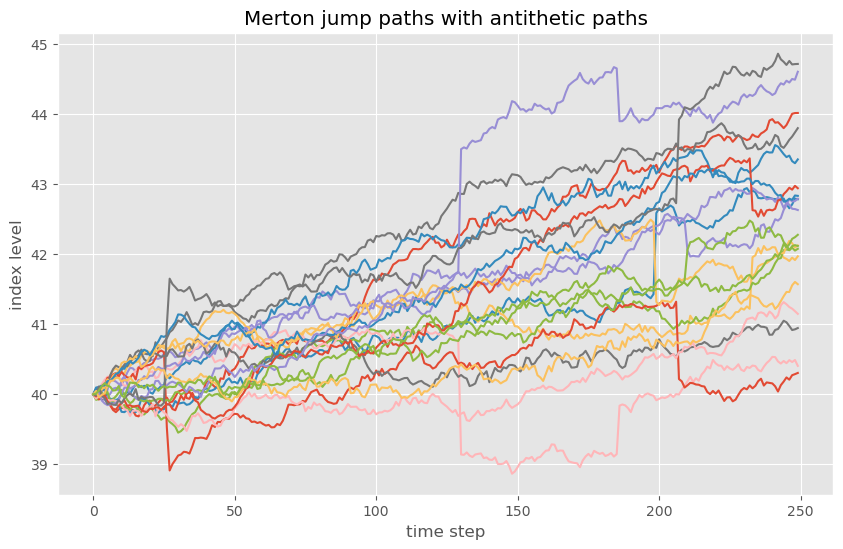

In [25]:
deg = 3
basis = 'legendre'
#initial price list
S0 = 40
K = 40

mu = 0.06
r = 0.06
T = 1
I = 250
paths = 10
m = 0

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = r
GBM_v = 0

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

df = np.exp(-mu*T)

# Generate the paths including antithetic paths
paths_with_antithetic = merton_jump_paths_antithetic(S0, paths, LN_lam, LN_sigma, LN_mu, LN_v, m, T, I)
paths_with_antithetic.shape  # Should be (2 * paths_example, I_example)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(paths_with_antithetic.T)
ax.set_xlabel('time step')
ax.set_ylabel('index level')
ax.set_title('Merton jump paths with antithetic paths')
plt.show()


In [18]:
import numpy as np

def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE

In [19]:
deg = 3
basis = 'legendre'
#initial price list
S0 = 40
K = 40

mu = 0.06
r = 0.06
T = 1
I = 50
paths = 10000
m = 0

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = r
GBM_v = 0

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

df = np.exp(-mu*T)

In [20]:
S = merton_jump_paths(S0, paths, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, T, I)
Price = LSM(K, S, I, df, basis, deg)[0]

S_anti = merton_jump_paths_antithetic(S0, paths, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, T, I)
Price_anti = LSM(K, S_anti, I, df, basis, deg)[0]

In [21]:
print('Price of the option is: ', Price)
print('Standard error is: ', LSM(K, S, I, df, basis, deg)[2])
print('Price of the option with antithetic paths is: ', Price_anti)
print('Standard error is: ', LSM(K, S_anti, I, df, basis, deg)[2])

Price of the option is:  0.13105296108160663
Standard error is:  0.0015586595417812444
Price of the option with antithetic paths is:  0.1292855538401134
Standard error is:  0.0010955750549829452


In [22]:
S = merton_jump_paths(S0, paths, LN_lam, LN_sigma, LN_mu, LN_v, m, T, I)
Price = LSM(K, S, I, df, basis, deg)[0]

S_anti = merton_jump_paths_antithetic(S0, paths, LN_lam, LN_sigma, LN_mu, LN_v, m, T, I)
Price_anti = LSM(K, S_anti, I, df, basis, deg)[0]

In [23]:
print('Price of the option is: ', Price)
print('Standard error is: ', LSM(K, S, I, df, basis, deg)[2])

print('Price of the option with antithetic paths is: ', Price_anti)
print('Standard error is: ', LSM(K, S_anti, I, df, basis, deg)[2])

Price of the option is:  0.06542303401246999
Standard error is:  0.0015253567939482397
Price of the option with antithetic paths is:  0.0644959364938346
Standard error is:  0.0010330883030696743
